In [13]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import scipy.fftpack as fftp
import cv2
import util
import myocyteFigs as mF
import copy
import imutils
import tissue
import time
plt.rcParams['figure.figsize'] = [16,9]

In [2]:
class empty:pass
cases = dict()

In [3]:
def highpass(transform,threshold):
    filtered = transform.copy()
    filtered[filtered < threshold] = 0
    return filtered

In [19]:
def givePS(array):
    start = time.time()
    dims = np.shape(array)
    psd = np.absolute(array)
    end = time.time()
    
    return psd

In [5]:
case=empty()
# want 200x200 uM subsection in WT region
case.loc_um = [3923,0] # need to define from upper-left corner of ROI in fiji
case.extent_um = [200,200]

cases['wtlike'] = case

In [6]:
tissue.SetupCase(cases['wtlike'])

Extracting 199x170 region from 3916x4093 image


WILL MAKE INTO CLASS LATER
Be sure to update ParamDict constructor once params are optimized
22.5
Extracting 199x170 region from 3916x4093 image
0
Call me debug
Writing file corr.png


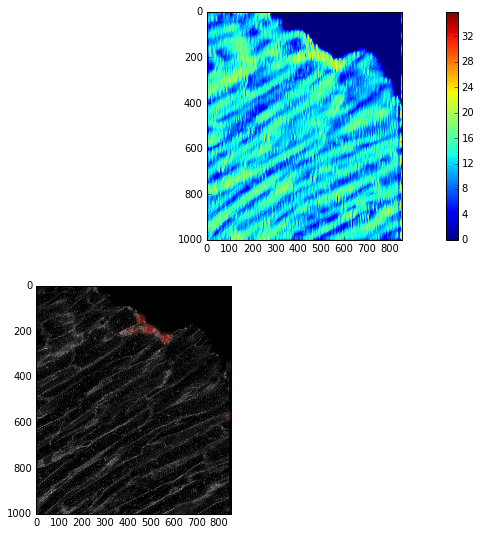

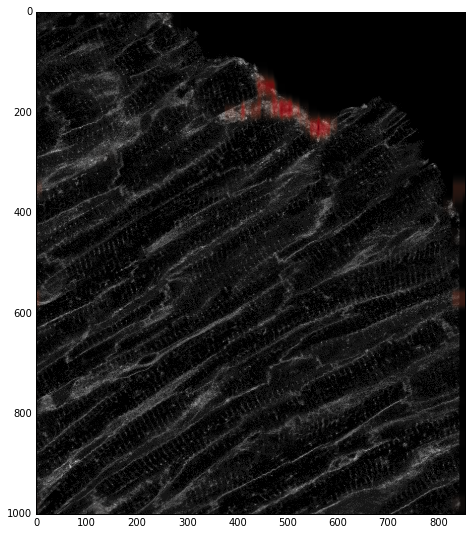

In [7]:
tissue.SetupFilters()
paramDict = tissue.SetupParams()
print paramDict['snrThresh']
results = tissue.Run(case,paramDict=paramDict)

### Reorient Image

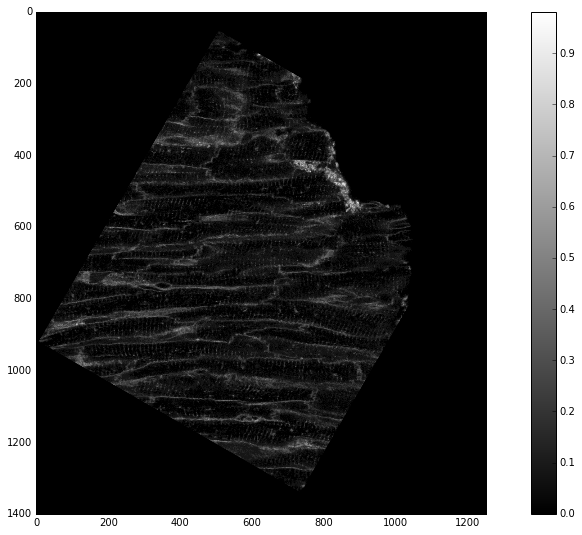

In [8]:
img = case.subregion.copy().astype(float)
img /= np.max(img)

img = util.PadWithZeros(img, 200)
img = imutils.rotate(img, -30)

dims = np.shape(img)

imshow(img,cmap='gray')
colorbar()

In [9]:
sdimg = img.copy()
transform1 = fftp.fft2(sdimg)

In [25]:
new1 = fftp.fftshift(transform1.copy())
PS1 = np.real(givePS(new1.copy()))

Time elapsed to calculate PSD: 0.0529329776764


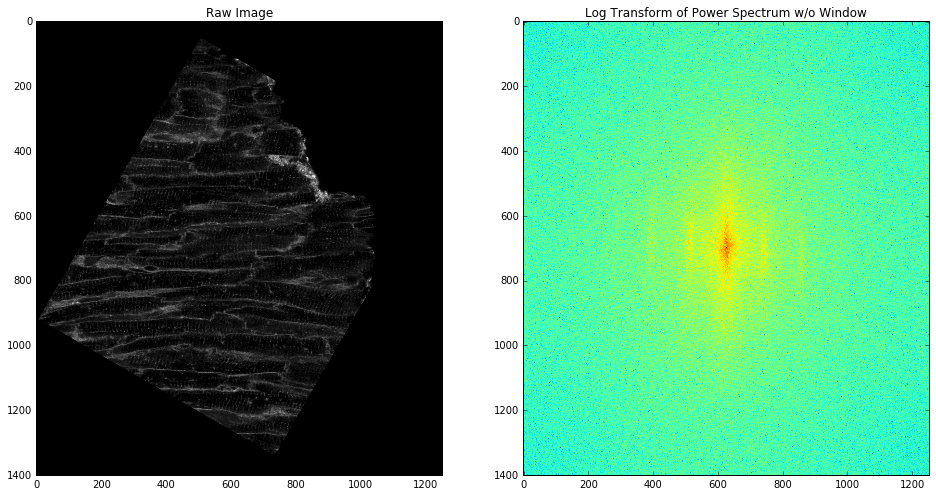

In [26]:
plt.figure()
f,axar = plt.subplots(1,2)
axar[0].imshow(img,cmap='gray')
axar[0].set_title("Raw Image")
axar[1].imshow(np.log(PS1))
axar[1].set_title("Log Transform of Power Spectrum w/o Window")
plt.show()

### Create Gaussian Fourier Domain Mask

(0, 1)

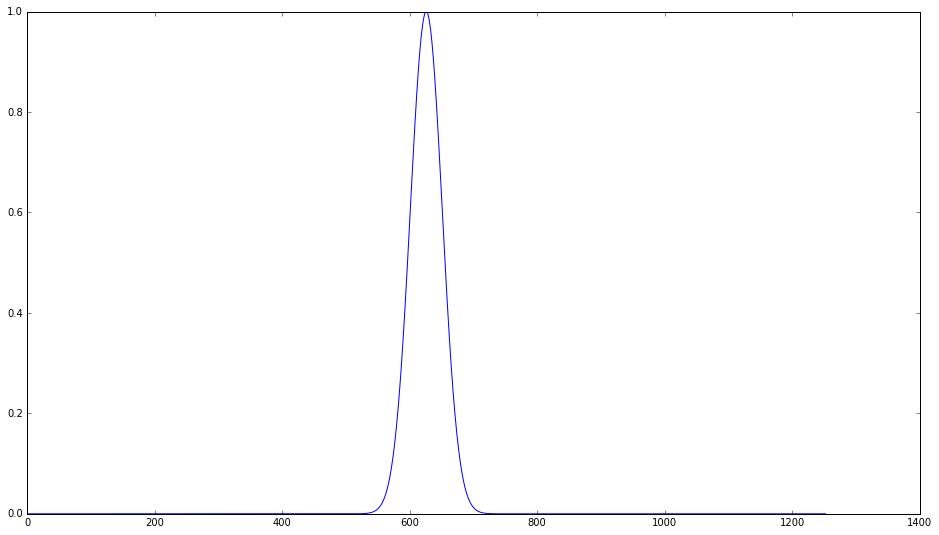

In [168]:
sigma = 25
import scipy as sp
gaussMask = sp.signal.gaussian(dims[1],sigma)
gaussMask /= np.max(gaussMask)


plt.plot(gaussMask)
plt.ylim([0,1])

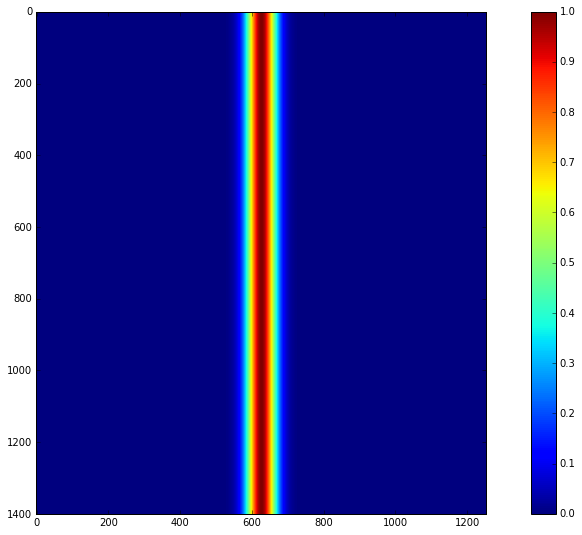

In [43]:
mask = np.zeros_like(img)
for row in range(np.shape(img)[0]):
    mask[row,:] = gaussMask
imshow(mask)
colorbar()

### Multiply Fourier Transform by Mask

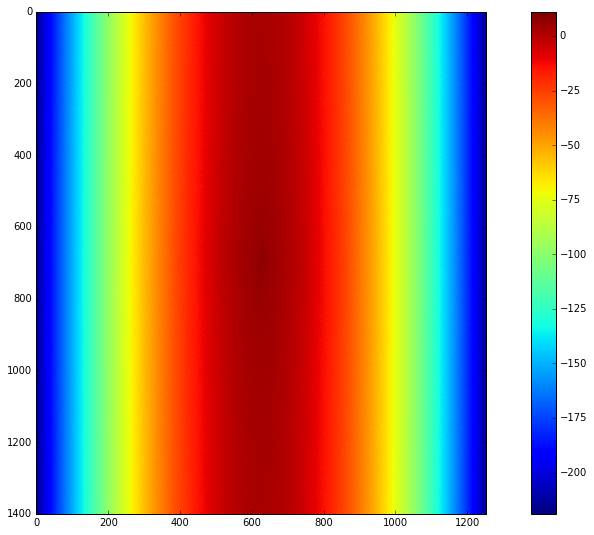

In [44]:
#masked = np.multiply(new1, mask)
masked = np.multiply(new1, mask)
real = np.real(givePS(masked.copy()))

imshow(np.log(real))
colorbar()

In [171]:
ishift = fftp.ifftshift(masked)
h = np.real(fftp.ifft2(ishift))
#h = fftp.ifftshift(h)

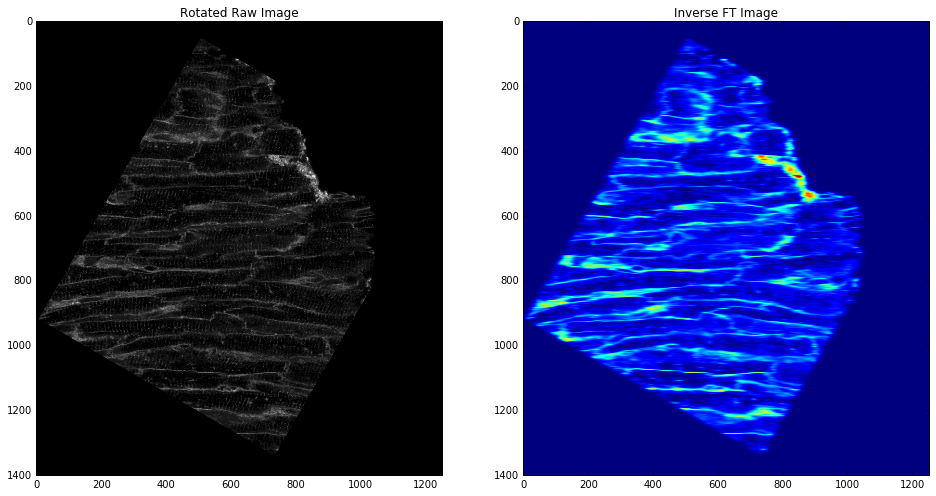

In [172]:
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(img,cmap='gray')
ax1.set_title("Rotated Raw Image")
ax2.imshow(h)
ax2.set_title("Inverse FT Image")

### Seemed to highlight edges. Trying band pass with 2 gaussians

35


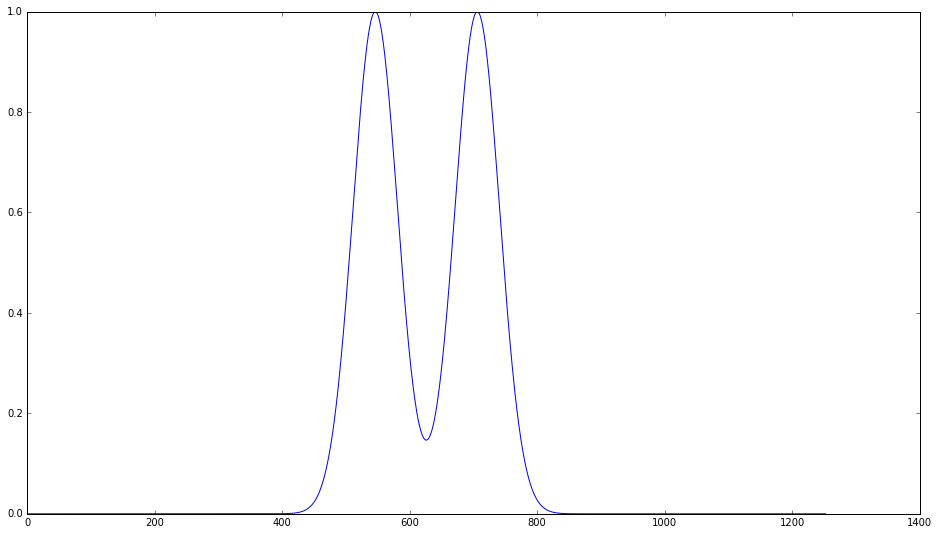

In [273]:
offset = 80
sigma = 35
print sigma

domain = range(0, dims[1], 1)
#print domain
gauss = lambda x: (1./(sigma*sqrt(2*np.pi))) * \
        ( exp(-0.5 * (float((x-(int(float(len(domain))/2.)+offset)))/sigma)**2) + \
         exp(-0.5 * (float((x-(int(float(len(domain))/2.)-offset)))/sigma)**2) \
         )
         #+ exp(-0.5 * (float((x-(int(float(len(domain))/2.)+2*offset)))/sigma)**2) + \
         #exp(-0.5 * (float((x-(int(float(len(domain))/2.)-2*offset)))/sigma)**2) )
func = np.asarray([gauss(x) for x in domain])
func /= np.max(func)
    
plt.plot(domain, func)

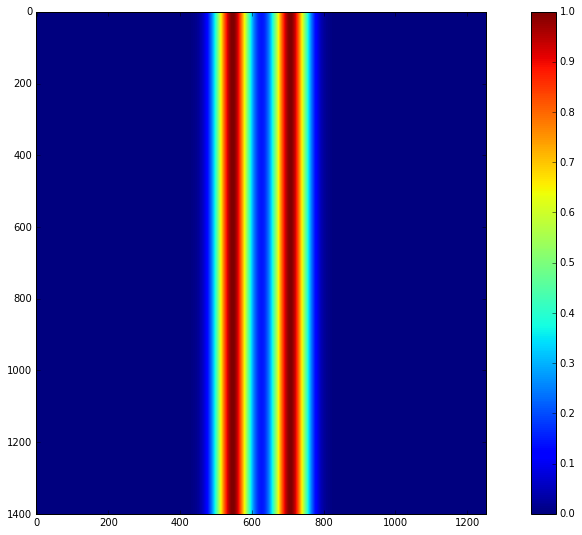

In [274]:
bimodal = np.zeros_like(img)
for row in range(np.shape(img)[0]):
    bimodal[row,:] = func
imshow(bimodal)
colorbar()

In [275]:
masked = np.multiply(new1, bimodal)
ishift = fftp.ifftshift(masked)
h = np.real(fftp.ifft2(ishift))
#h = fftp.ifftshift(h)

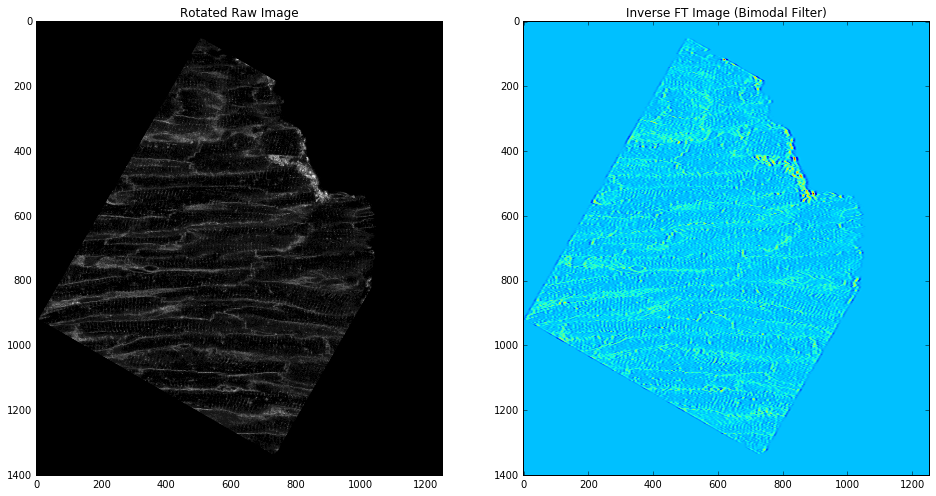

In [276]:
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(img,cmap='gray')
ax1.set_title("Rotated Raw Image")
ax2.imshow(h)
ax2.set_title("Inverse FT Image (Bimodal Filter)")

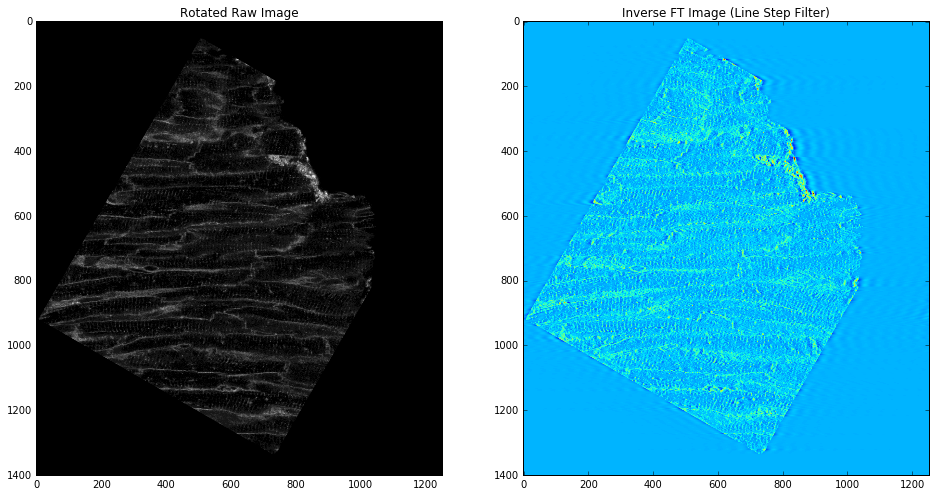

In [272]:
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(img,cmap='gray')
ax1.set_title("Rotated Raw Image")
ax2.imshow(h)
ax2.set_title("Inverse FT Image (Line Step Filter)")

### Do inverse filtering over again since you're a dummy and you deleted everything

(0, 1)

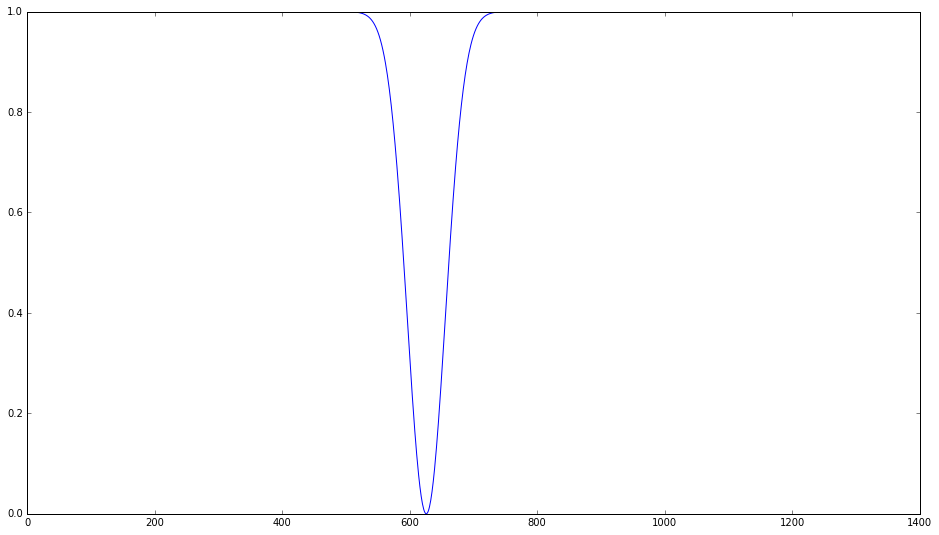

In [41]:
sigma = 30
import scipy as sp
gauss = sp.signal.gaussian(dims[1],sigma)
gauss /= np.max(gauss)
invGauss = 1- gauss

plt.plot(invGauss)
plt.ylim([0,1])

#### Make 2D

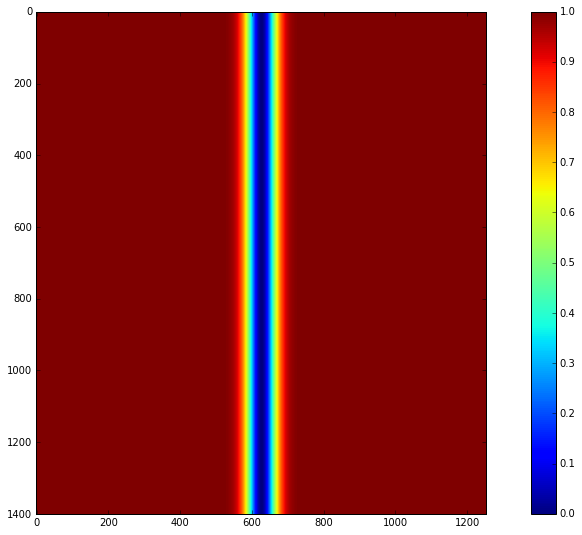

In [42]:
notch = np.zeros_like(img)
for row in range(np.shape(img)[0]):
    notch[row,:] = invGauss
imshow(notch)
colorbar()

#### Apply to filter to Fourier domain and display PS

In [45]:
filtered = np.multiply(notch, new1.copy())
filteredPS = np.real(givePS(filtered.copy()))

-c:2: RuntimeWarning: divide by zero encountered in log


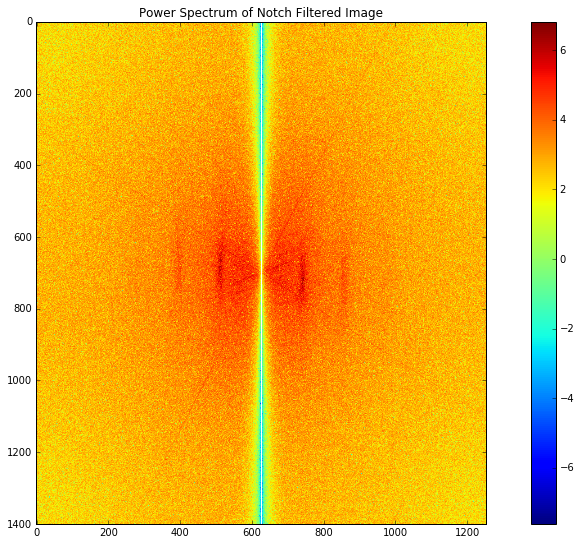

In [47]:
plt.figure()
plt.imshow(np.log(filteredPS))
plt.colorbar()
plt.title("Power Spectrum of Notch Filtered Image")

#### Now take inverse fourier transform of the image

In [51]:
invShifted = sp.fftpack.ifftshift(filtered)
notchedImg = np.real(fftp.ifft2(invShifted))

# have to add minimum of the iFT image since the filtering knocks down the mean by taking out signal
notchedMin = np.min(notchedImg)
eps = 1./255. # error factor

notchedImg += np.abs(notchedMin)
notchedImg[notchedImg < np.abs(notchedMin)+eps] = 0


In [61]:
print notchedMin

-0.349302894745


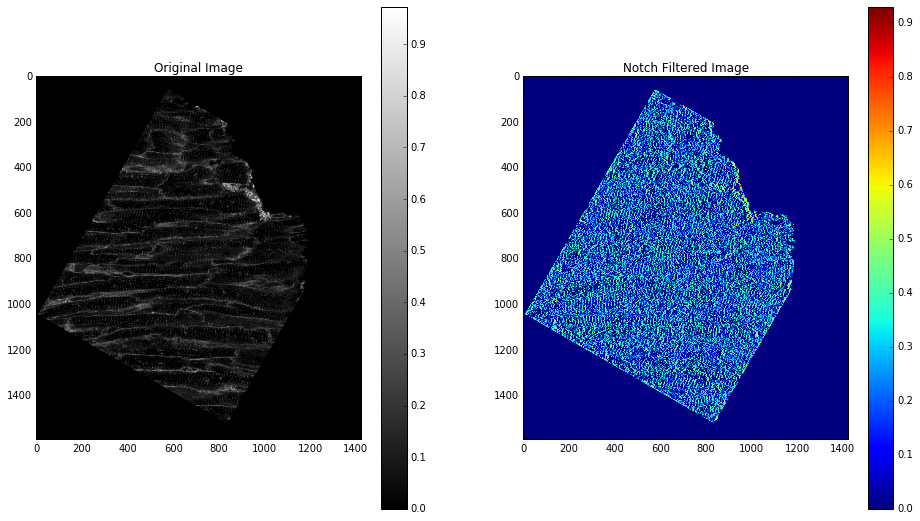

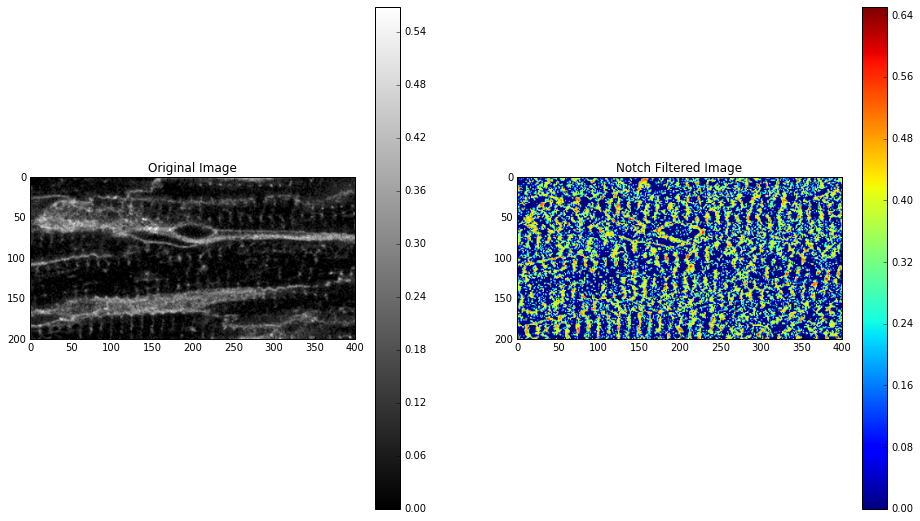

In [71]:


displayAll = True
if displayAll:
    f,axar = plt.subplots(1,2)
    im = axar[0].imshow(img,cmap='gray')
    axar[0].set_title("Original Image")
    f.colorbar(im,ax=axar[0])
    new = axar[1].imshow(notchedImg)
    axar[1].set_title("Notch Filtered Image")
    f.colorbar(new,ax=axar[1])

displaySubsection = True
if displaySubsection:
    f,axar = plt.subplots(1,2)
    im = axar[0].imshow(img[800:1000,200:600],cmap='gray')
    axar[0].set_title("Original Image")
    f.colorbar(im,ax=axar[0])
    new = axar[1].imshow(notchedImg[800:1000,200:600])
    axar[1].set_title("Notch Filtered Image")
    f.colorbar(new,ax=axar[1])

Notice that there is still appreciable amounts of signal left from the membranes. This is by design since we want something for the punishment filter to pick up on

#### Setup for detection procedures

In [65]:
print np.max(notchedImg)
print np.max(img)

0.923301336594
0.9814453125


In [66]:
# the image seems to have a two sarcomere length of ~22, so let's resize
img *= 255
img = np.asarray(img,dtype='uint8')
notchedImg *= 255
notchedImg = np.asarray(notchedImg,dtype='uint8')

scale = 25. / 22. # filter sarc size / image sarc size
img = cv2.resize(img,None,fx=scale,fy=scale,interpolation=cv2.INTER_CUBIC) / 255.
notchedImg = cv2.resize(notchedImg,None,fx=scale,fy=scale,interpolation=cv2.INTER_CUBIC) / 255.

In [67]:
import optimizer

inputsOrig = empty()
inputsOrig.img = img
inputsOrig.mf = util.ReadImg("./myoimages/WTFilter.png",renorm=True)
inputsOrig.imgOrig = img
inputsOrig.mfOrig = util.ReadImg("./myoimages/WTFilter.png",renorm=True)

iters = [0]

returnAngles = False

inputs = empty()
inputs.img = notchedImg
inputs.mf = util.ReadImg("./myoimages/WTFilter.png",renorm=True)
inputs.imgOrig = notchedImg
inputs.mfOrig = util.ReadImg("./myoimages/WTFilter.png",renorm=True)

WTparams = optimizer.ParamDict(typeDict='WT')
WTparams['mfPunishment'] = util.ReadImg("./myoimages/WTPunishmentFilter.png",renorm=True)
WTparams['covarianceMatrix'] = np.ones_like(img)

WILL MAKE INTO CLASS LATER
Be sure to update ParamDict constructor once params are optimized


#### Perform matched filtering

In [68]:
import bankDetect as bD
WTresultsOrig = bD.DetectFilter(inputsOrig,WTparams,iters,returnAngles=returnAngles)

WTresults = bD.DetectFilter(inputs,WTparams,iters,returnAngles=returnAngles)

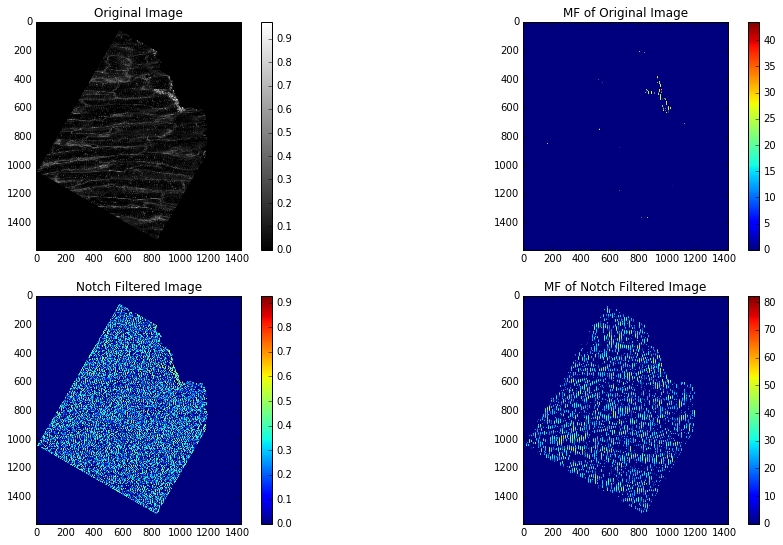

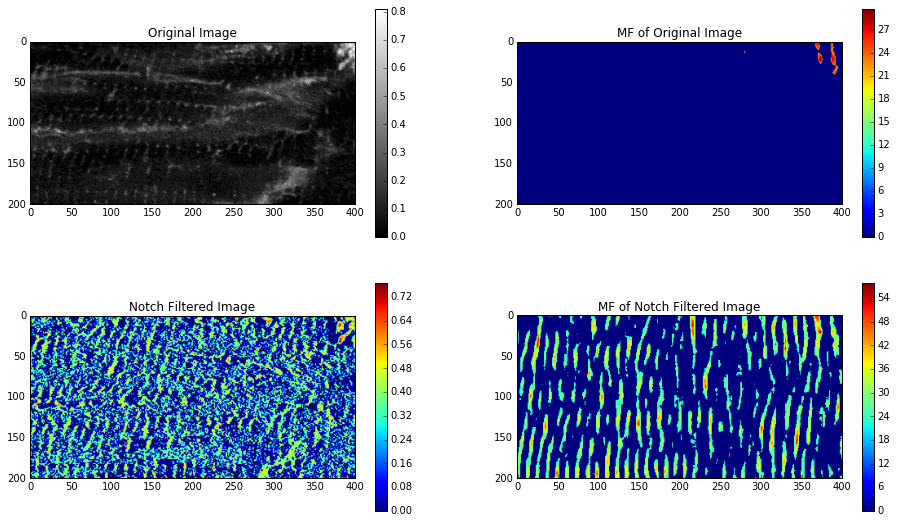

In [69]:
displayAll = True
if displayAll:
    f,axar = plt.subplots(2,2)
    
    im = axar[0,0].imshow(img,cmap='gray')
    axar[0,0].set_title("Original Image")
    f.colorbar(im,ax=axar[0,0])
    
    origMF = axar[0,1].imshow(WTresultsOrig.stackedHits)
    axar[0,1].set_title("MF of Original Image")
    f.colorbar(origMF,ax=axar[0,1])
    
    new = axar[1,0].imshow(notchedImg)
    axar[1,0].set_title("Notch Filtered Image")
    f.colorbar(new,ax=axar[1,0])
    
    newMF = axar[1,1].imshow(WTresults.stackedHits)
    axar[1,1].set_title("MF of Notch Filtered Image")
    f.colorbar(newMF,ax=axar[1,1])
    plt.show()

displaySubsection = True
if displaySubsection:
    f,axar = plt.subplots(2,2)
    
    im = axar[0,0].imshow(img[600:800,600:1000],cmap='gray')
    axar[0,0].set_title("Original Image")
    f.colorbar(im,ax=axar[0,0])
    
    origMF = axar[0,1].imshow(WTresultsOrig.stackedHits[600:800,600:1000])
    axar[0,1].set_title("MF of Original Image")
    f.colorbar(origMF,ax=axar[0,1])
    
    new = axar[1,0].imshow(notchedImg[600:800,600:1000])
    axar[1,0].set_title("Notch Filtered Image")
    f.colorbar(new,ax=axar[1,0])
    
    newMF = axar[1,1].imshow(WTresults.stackedHits[600:800,600:1000])
    axar[1,1].set_title("MF of Notch Filtered Image")
    f.colorbar(newMF,ax=axar[1,1])
    plt.show()

#### Write notch filtered image for use in Pete's gpu script

In [70]:
writtenImg = np.asarray(notchedImg * 255,dtype='uint8')

cv2.imwrite("./testingNotchFilter.png",writtenImg)

True

In [73]:
# also write the new 'original' image
writtenTissue = np.asarray(img * 255,dtype='uint8')
cv2.imwrite("./rotatedTissue.png", writtenTissue)

True

#### Do some bastardization of giveMarkedMyocyte() to mark the WT portions

In [ ]:
inputs = empty()
inputs.imgOrig = img[400:800, 400:800] # use small subset to test image

